# Load Data


In [1]:
!pip install gdown

In [2]:
#!gdown "1cPVlwaiZZafrMMm37ylUVJjdrUd--ofh"

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1cPVlwaiZZafrMMm37ylUVJjdrUd--ofh

but Gdown can't. Please check connections and permissions.


In [ ]:
#!unzip /kaggle/working/dataset.zip

# Edit .yaml file

In [ ]:
# %%writefile /kaggle/working/dataset/data.yaml
# path: /kaggle/working/dataset 
# train: train/images 
# val: val/images 
# test: 

# names:
#     0: red
#     1: green
#     2: yellow
#     3: off


# Load YOLOV8

In [ ]:
#from ultralytics import YOLO
#model = YOLO("yolov8n.yaml")
#results = model.train(data="/kaggle/working/dataset/data.yaml", batch=-1, save_period=5, epochs=60, imgsz=640)

# Save The model

In [ ]:
#exported_model_path = model.export(format="saved_model")

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.7/881.7 kB 34.1 MB/s eta 0:00:00


# Load saved model

In [2]:
from ultralytics import YOLO
import tensorflow as tf 
saved_model = YOLO("/kaggle/input/yolo/other/default/1/best (1).pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Image object detection

In [3]:
pip install opencv-python

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


Total number of frames in the video: 918

0: 384x640 2 greens, 84.1ms
Speed: 10.8ms preprocess, 84.1ms inference, 311.2ms postprocess per image at shape (1, 3, 384, 640)


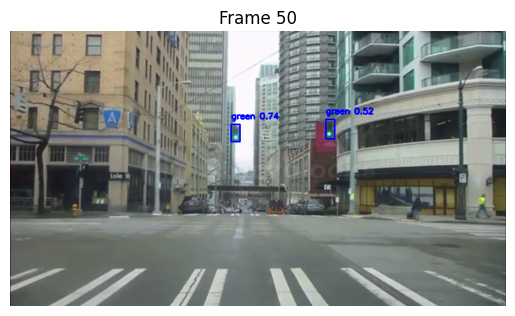


0: 384x640 2 reds, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


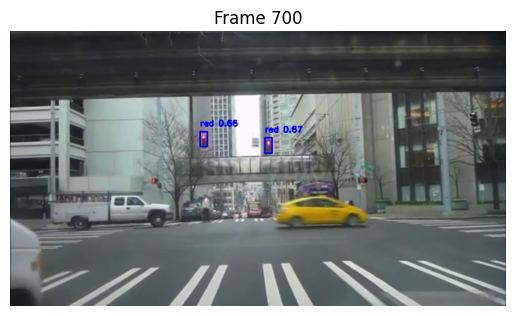


0: 384x640 3 reds, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


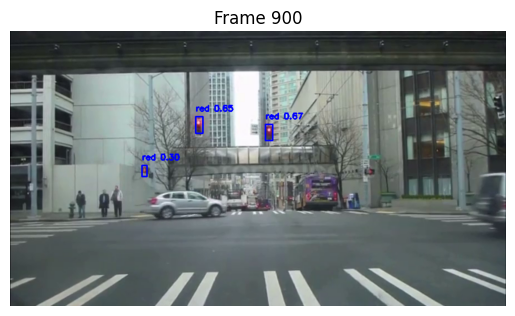

End of video or error.


In [4]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO 
video_path = '/kaggle/input/car-video/Car.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit() 
    
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total number of frames in the video: {total_frames}")
desired_frames = [50, 700, 900]
frame_id = 0
while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video or error.")
        break
    if frame_id in desired_frames:
        results = saved_model(frame)  
        boxes = results[0].boxes
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  
            conf = box.conf[0]
            cls = int(box.cls[0])
            label = f"{saved_model.names[cls]} {conf:.2f}"
       
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)  
        
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title(f"Frame {frame_id}")
        plt.show()
    frame_id += 1
cap.release()


# Video object tracking

In [ ]:
import torch 
import cv2

# Initialize video capture and model
video_path = '/kaggle/input/car-video/Car.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"Total number of frames in the video: {total_frames}, FPS: {fps}")

output_path = 'Output3.mp4'  
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Dictionary to track object detections over frames
object_track_count = {}

frame_id = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video or error.")
        break

    # Crop the frame to the upper half
    upper_half_frame = frame[:height // 2, :]

    # Perform object detection on the upper half of the frame
    results = saved_model.track(upper_half_frame, persist=True, conf = 0.10)[0]
    
    if results.boxes is not None and len(results.boxes) > 0:
        boxes = results.boxes
        track_ids = boxes.id.tolist() if boxes.id is not None else []

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            light_id = track_ids[i] if i < len(track_ids) else 'N/A'
            conf = box.conf[0]
            cls = int(box.cls[0])
            label = f"{saved_model.names[cls]} {conf:.2f}"

            # Update tracking dictionary for object detection
            if light_id != 'N/A':  # Check for valid object ID
                if light_id not in object_track_count:
                    object_track_count[light_id] = 1
                else:
                    object_track_count[light_id] += 1

                # Filter objects that have been detected for more than 10 frames
                if object_track_count[light_id] > 10:
                    print(f"Object {light_id} detected for more than 10 frames.")

                    # Draw the bounding box directly on the upper_half_frame
                    if conf >= 0.1:
                        if 'red' in saved_model.names[cls].lower():
                            color = (0, 0, 255)  # Red bounding box
                        elif 'green' in saved_model.names[cls].lower():
                            color = (0, 255, 0)  # Green bounding box
                        elif 'yellow' in saved_model.names[cls].lower():
                            color = (0, 255, 255)  # Yellow bounding box
                        else:
                            color = (255, 0, 0)

                        cv2.rectangle(upper_half_frame, (x1, y1), (x2, y2), color, 2)
                        cv2.putText(upper_half_frame, f"{light_id}: {label}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Replace the upper half of the original frame with the processed one
    frame[:height // 2, :] = upper_half_frame

    # Write the full frame with the processed upper half to the output video
    out.write(frame)
    frame_id += 1

    # Clean up: Remove objects that haven't been detected in the last few frames
    lost_ids = []
    for light_id in object_track_count:
        if light_id not in track_ids:
            object_track_count[light_id] -= 1  # Decrement counter when not detected
            if object_track_count[light_id] <= 0:
                lost_ids.append(light_id)

    # Remove objects that have not been detected for a while
    for lost_id in lost_ids:
        del object_track_count[lost_id]

cap.release()
out.release()



Total number of frames in the video: 918, FPS: 30.656203038904657

0: 192x640 2 greens, 8.7ms
Speed: 1.6ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 192, 640)

0: 192x640 2 greens, 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 192, 640)

0: 192x640 2 greens, 7.4ms
Speed: 1.4ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 640)

0: 192x640 2 greens, 6.8ms
Speed: 1.0ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 640)

0: 192x640 2 greens, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 640)

0: 192x640 2 greens, 6.6ms
Speed: 1.4ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 640)

0: 192x640 2 greens, 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 192, 640)

0: 192x640 2 greens, 6.7ms
Speed: 1.1ms preprocess, 6.7ms inferen

In [5]:
!pip install pytube

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.4 MB/s eta 0:00:00


In [11]:
from pytube import YouTube

# Function to download video
def download_video(url, save_path='.'):
    try:
        yt = YouTube(url)
        print(f"Downloading: {yt.title}")
        stream = yt.streams.filter(progressive=True, file_extension='mp4').get_highest_resolution()
        stream.download(output_path=save_path)
        print("Download completed!")
    except Exception as e:
        print(f"Error: {e}")

# Example usage
video_url = 'https://www.youtube.com/watch?v=iS5sq9IELEo'
download_video(video_url)


Downloading: Lane Lines, Traffic Lights and Traffic Signs: Driving Lesson/Tips For New Drivers
Error: HTTP Error 400: Bad Request


In [9]:
!pip install youtube_dl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.9 MB/s eta 0:00:0000:01
